In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import csv
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import itertools

# for named entity
from nltk import word_tokenize, pos_tag, ne_chunk, tree, download, tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# for preparing data
download('vader_lexicon')
%matplotlib inline


# nltk for natural language processing

/Users/chitrankdixit/Documents/work/sentimental_analysis/sentimental/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chitrankdixit/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
path =r'./playstorereviewsdata/' # use your path
allFiles = glob.glob(path + "/*.tsv")

review_data = [];
count = 0
for out_count, file in enumerate(allFiles):
    with open(file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        #import pdb;pdb.set_trace()
        for counter, row in enumerate(spamreader):
            #import pdb;pdb.set_trace()
            count += 1
            if counter == 0:
                text_index = row.index("Review Text")
                title_index = row.index("Review Title")
                rating_index = row.index("Star Rating")
                #print(text_index, title_index, rating_index)
            else:
                for item in row[text_index].split('.'):
                    if not re.findall(r'[\w.-]+@[\w.-]+',item):
                        review_data.append({
                            "Review Text": item,
                            "Review Title": row[title_index],
                            "Star Rating": int(row[rating_index])
                        })
            
#     with open(file+out_count, 'wt') as csvfile:
#             writer = csv.writer(csvfile, delimiter='', quotechar='|')
#             #writer.writerow(["#"] + anarkali_characteristics)
#             #import pdb;pdb.set_trace()
#             for element in lehenga_characteristics:
#                 #import pdb;pdb.set_trace()
#                 writer.writerow([element["name"], element["count"]])

In [3]:
# get full data


frame = pd.DataFrame()
list_ = []

# datacolumns = [
#     "Package Name",
#     "App Version Code",
#     "Reviewer Language",
#     "Device",
#     "Review Submit Date and Time",
#     "Review Submit Millis Since Epoch",
#     "Review Last Update Date and Time",
#     "Review Last Update Millis Since Epoch",
#     "Star Rating",
#     "Review Title",
#     "Review Text",
#     "Developer Reply Date and Time",
#     "Developer Reply Millis Since Epoch",
#     "Developer Reply Text,Review Link"
# ]

# for item in allFiles:
    

# for file_ in allFiles:
#     df = pd.read_csv(file_,index_col=None, header=0, encoding = "ISO-8859-1", error_bad_lines=False, sep='\t')
#     list_.append(df)
    
    
# full_data = pd.concat(list_)

#import pdb;pdb.set_trace()
full_data = pd.DataFrame(review_data)
full_data.count()

# import pdb;pdb.set_trace()
# full_data1 = pd.concat(list_)
# full_data1.count()

Review Text     22790
Review Title    22790
Star Rating     22790
dtype: int64

In [4]:
# remove the NaN 
full_data["Review Text"] = full_data["Review Text"].fillna('')
full_data["Review Title"] = full_data["Review Title"].fillna('')
# full_data["App Version Code"] = full_data["App Version Code"].fillna(0.0)
# full_data["App Version Name"] = full_data["App Version Name"].fillna('')
# full_data["Developer Reply Date and Time"] = full_data["Developer Reply Date and Time"].fillna('')
# full_data["Developer Reply Millis Since Epoch"] = full_data["Developer Reply Millis Since Epoch"].fillna('')
# full_data["Developer Reply Text"] = full_data["Developer Reply Text"].fillna('')

# slicing the required columns only
#full_data = full_data[["Review Text", "Review Title", "Star Rating"]]

In [5]:
full_data.head(5)

,Review Text,Review Title,Star Rating
0,This is a brilliant concept,Great product!,5
1,Please start for men's asap,Great product!,5
2,Brilliant concept :),,5
3,,,5
4,Brilliant stuff!! Waiting to see more,,5


In [6]:
full_data = full_data.loc[full_data['Review Text'] != '']


sid = SentimentIntensityAnalyzer()
#import pdb;pdb.set_trace()


# print(full_data['Review Text'].tolist()[0])
# ss = sid.polarity_scores(full_data['Review Text'].tolist()[0])
# print(ss)


# add a named entities to look for
#import pdb;pdb.set_trace()

def get_sentiment_score(item):
    sentences = item['Review Text']
    
    ss = sid.polarity_scores(sentences)
    negative = ss["neg"]
    positive = ss["pos"]
    neutral = ss["neu"]
    #compound = ss["compound"]
    return pd.Series({'negative': negative, 'positive': positive, 'neutral': neutral})


scores = full_data.apply(get_sentiment_score, axis=1)

final_sliced_data = pd.concat([ full_data , scores], axis=1)

In [7]:
final_sliced_data.head(5)

,Review Text,Review Title,Star Rating,negative,neutral,positive
0,This is a brilliant concept,Great product!,5,0.0,0.441,0.559
1,Please start for men's asap,Great product!,5,0.0,0.635,0.365
2,Brilliant concept :),,5,0.0,0.128,0.872
4,Brilliant stuff!! Waiting to see more,,5,0.0,0.533,0.467
8,This idea will be considered as one of the top...,Excellent,5,0.0,0.886,0.114


In [8]:
# generate csv file
final_sliced_data.to_csv("review_text_data.tsv", sep='\t')

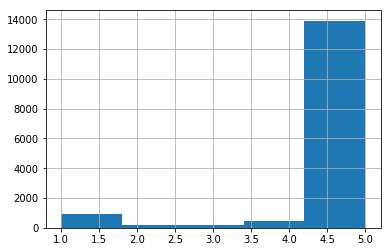

In [9]:
final_sliced_data['Star Rating'].hist(bins=5)

In [10]:
final_sliced_data.to_csv('pos_neg_score.csv', index = False)

In [11]:
# 0 -> neutral
# 1 -> negative
# 2 -> positive
# 3 -> compound
print(final_sliced_data.loc[final_sliced_data['negative'] == 0.0].__len__())
print(final_sliced_data.loc[final_sliced_data['positive'] == 0.0].__len__())
print(final_sliced_data.loc[final_sliced_data['neutral'] == 0.0].__len__())
#print(final_sliced_data.loc[final_sliced_data['compound'] == 0.0].__len__())

def get_sentiment_class(item):
    sentiment_class = 0
    score_list = [item['neutral'], item['negative'], item['positive']]
    max_val = max(score_list)
    
    sentiment_class = score_list.index(max_val)
    
    return pd.Series({'sentiment_class': sentiment_class})


score_class = final_sliced_data.apply(get_sentiment_class, axis=1)

input_data = pd.concat([ final_sliced_data , score_class], axis=1)


13477
3970
546


In [12]:
print(input_data.loc[input_data['sentiment_class'] == 0].__len__())
print(input_data.loc[input_data['sentiment_class'] == 1].__len__())
print(input_data.loc[input_data['sentiment_class'] == 2].__len__())
#print(input_data.loc[input_data['sentiment_class'] == 3].__len__())

13207
158
2296


In [13]:
neutral_data = input_data.loc[(input_data['sentiment_class'] == 0)][:158]
negative_data = input_data.loc[(input_data['sentiment_class'] == 1)][:158]
positive_data = input_data.loc[(input_data['sentiment_class'] == 2)][:158]
#compound_data = input_data.loc[(input_data['sentiment_class'] == 3)][:158]
# add a named entities to look for
#import pdb;pdb.set_trace()

intermediate_data1 = positive_data.append(negative_data)
sliced_data = intermediate_data1.append(neutral_data)


In [14]:
print(sliced_data.loc[sliced_data['sentiment_class'] == 0].__len__())
print(sliced_data.loc[sliced_data['sentiment_class'] == 1].__len__())
print(sliced_data.loc[sliced_data['sentiment_class'] == 2].__len__())
#print(sliced_data.loc[sliced_data['sentiment_class'] == 3].__len__())

158
158
158


In [15]:
sliced_data.tail(5)

,Review Text,Review Title,Star Rating,negative,neutral,positive,sentiment_class
528,Came across this app through fb promotions,"Beautiful app, necessary to experience",5,0.0,1.000,0.000,0
529,Was surprised to think why nobody ever did th...,"Beautiful app, necessary to experience",5,0.0,0.705,0.295,0
530,"Anyway, like the concept, affordable pricing ...","Beautiful app, necessary to experience",5,0.0,0.737,0.263,0
538,The pictures just don't load! I have a 4g conn...,Very slow,2,0.0,0.870,0.130,0
541,I dont have fb account,login without fb account??,2,0.0,1.000,0.000,0


In [16]:
class VaderVectorizer:
    """
    """
    
    def __init__(self):
        pass
    
    def extract_classes(self):
        pass
    
def format_sentence(sent):
    return({word: True for word in word_tokenize(sent)})
        

In [18]:
labels = sliced_data["sentiment_class"].values;

#import pdb;pdb.set_trace()  
kf = StratifiedKFold(n_splits=4)


totalNBV = 0

totalMatMLP = np.zeros((3,3));

# tr, te = kf.split(sliced_data['Review Text'], labels)
# td = []
# for i in train_index:
#     td.append(sliced_data['Review Text'][i])
#import pdb;pdb.set_trace()
review_text = sliced_data['Review Text'].tolist()

# break words
review_words = []

# for item in review_text:
#     review_words += item.split(" ")
counter = 0
for train_index, test_index in kf.split(review_text, labels):
    #import pdb;pdb.set_trace()
    #print(train_index.__len__(), test_index.__len__())
    #X_train = [review_text[i] for i in train_index]
    #X_test = [review_text[i] for i in test_index]
    #import pdb;pdb.set_trace()
    X_train_nb = [[format_sentence(review_text[i]), int(sliced_data.iloc[i]['sentiment_class'])] for i in train_index]
    X_test_nb = [[format_sentence(review_text[i]), int(sliced_data.iloc[i]['sentiment_class'])] for i in test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
#     vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=False, stop_words='english')
#     train_corpus_tf_idf = vectorizer.fit_transform(X_train) 
#     test_corpus_tf_idf = vectorizer.transform(X_test)
    
    
    #vader_vectorizer = 
    #import pdb;pdb.set_trace()
    #import pdb;pdb.set_trace()
#     splitted_x_train = [item.split(' ') for item in X_train]
#     w = WordWeightAssign(splitted_x_train)
#     w.collect_data()
#     w.score_words()
#     train_corpus_scores = w.score_words()
    
#     splitted_x_test = [item.split(' ') for item in X_test]
#     w = WordWeightAssign(splitted_x_test)
#     w.collect_data()
#     w.score_words()
#     test_corpus_scores = w.score_words()
    #model1 = LinearSVC()
    #model2 = MultinomialNB()
    #model3 = MLPClassifier()
    nb = MultinomialNB()
    # Max entropy
    #model1.fit(train_corpus_tf_idf,y_train)
    #model2.fit(train_corpus_tf_idf,y_train)
    #model3.fit(train_corpus_tf_idf,y_train)
    nb.fit(X_train_nb, y_train)
    
    #result1 = model1.predict(test_corpus_tf_idf)
    #result2 = model2.predict(test_corpus_tf_idf)
    #result3 = model3.predict(test_corpus_tf_idf)
    result4 = nb.predict(X_test_nb)
    
    #test1 = model1.score(test_corpus_tf_idf, y_test)
    #test2 = model2.score(test_corpus_tf_idf, y_test)
    #test3 = model3.score(test_corpus_tf_idf, y_test)
    test4 = nb.score(X_test_nb, y_test)
    print(test4)
    
    #totalMatSvm = totalMatSvm + confusion_matrix(y_test, result1)
    #totalMatNB = totalMatNB + confusion_matrix(y_test, result2)
    totalMatNBV = totalMatNBV + confusion_matrix(y_test, result4)
    #totalMatMLP = totalMatMLP + confusion_matrix(y_test, result3)
    #totalsvm = totalsvm + sum(y_test==result1)
    #totalNB = totalNB + sum(y_test==result2)
    totalNBV = totalNBV + sum(y_test==result4)
    #totalMLP = totalMLP + sum(y_test==result3)
    counter += 1
    test_data = ["I do not liked the service.", "What is the point of starting this when you can not deliver items on time", "Is it really working in India ?"]
#     splitted_x_test_ = [item.split(' ') for item in test_data]
#     w = WordWeightAssign(splitted_x_test_)
#     w.collect_data()
#     test_corpus = w.score_words()
    
#     result_test = nb.predict(test_corpus)
#     print(result_test)
    prev = sliced_data.iloc[test_index, :]
    test = pd.DataFrame( { 'Review Text': X_test , 'Sentiment': result4,
                          'Neutral': prev['neutral'],
                          'Positive': prev["positive"], 
                          'Negative': prev["negative"],
                         'Star Rating': prev["Star Rating"]} )
    test.to_csv( 'sentiment_prediction'+str(counter)+'.csv' , index = False )
    
    
print((totalNBV/474.0) * 100.00)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





plt.figure()
plot_confusion_matrix(totalMatNBV, classes=["neutral", "negative", "positive"], normalize=True,
                      title='confusion matrix')

plt.show()
#print(totalMatSvm, totalsvm, totalMatNB, totalNB, totalMatMLP, totalMLP)
#test.to_csv( 'sentiment_prediction.csv' , index = False )

#print(train_corpus_tf_idf, test_corpus_tf_idf)
#import pdb;pdb.set_trace()
#print(test_corpus_tf_idf, X_test[0])

#test_Y = model2.predict( test_corpus_tf_idf )
#print(test_Y)
#print(X_test)

#print(results_list)
#print(review_text.reset_index(drop=True))
#print(review_text)
# test = pd.DataFrame( { 'Review Text': review_text , 'Sentiment': test_Y } )
# test.shape
# test.head()
#test.to_csv( 'sentiment_prediction.csv' , index = False )

TypeError: float() argument must be a string or a number, not 'dict'